In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .5)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
pipe_scale = Pipeline(steps = [
    ('Scaler', scaler),
    ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction Decision Tree')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/3', experiment_id='3', lifecycle_stage='active', name='NBA MVP prediction Decision Tree', tags={}>

In [18]:
param_grid = {
    'max_depth': [7], 
    'min_samples_split': [10],
    'max_features': [.5, .7, .6]
    }

In [19]:
with mlflow.start_run():
    estimator = DecisionTreeRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_dt(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   3.2s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   4.0s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   3.1s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   3.2s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   3.2s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   2.6s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   2.4s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   2.9s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   3.0s
[CV] END max_depth=7, max_features=0.5, min_samples_split=10; total time=   2.8s
[CV] END max_depth=7, max_features=0.7, min_samples_split=10; total time=   3.4s
[CV] END max_depth=7, max_features=0.7, min_samp

2022/07/31 19:19:07 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpbd5l_cmv\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [20]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.049431,0.049356,0.039361
R2,0.884967,0.794487,0.516164


In [21]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [22]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.913001
263,2016,Kawhi Leonard,0.484,0.388547
222,2016,LeBron James,0.482,0.446248
452,2016,Russell Westbrook,0.371,0.200902
126,2016,Kevin Durant,0.112,0.626765
348,2016,Chris Paul,0.082,0.388547
167,2016,Draymond Green,0.038,0.018254
266,2016,Damian Lillard,0.020,0.062375
178,2016,James Harden,0.007,0.080531


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.458043
173,2017,James Harden,0.746,0.403953
261,2017,Kawhi Leonard,0.495,0.446248
221,2017,LeBron James,0.330,0.216133
425,2017,Isaiah Thomas,0.080,0.216133
98,2017,Stephen Curry,0.051,0.062375
16,2017,Giannis Antetokounmpo,0.007,0.062375
453,2017,John Wall,0.007,0.080531
100,2017,Anthony Davis,0.002,0.216133


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.376057
249,2018,LeBron James,0.731,0.266887
122,2018,Anthony Davis,0.441,0.312822
298,2018,Damian Lillard,0.205,0.062375
508,2018,Russell Westbrook,0.075,0.320957
16,2018,Giannis Antetokounmpo,0.074,0.154769
143,2018,Kevin Durant,0.065,0.062375
130,2018,DeMar DeRozan,0.032,0.059319
7,2018,LaMarcus Aldridge,0.006,0.005955


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.522608
207,2019,James Harden,0.768,0.626765
184,2019,Paul George,0.352,0.062375
270,2019,Nikola Jokić,0.210,0.018254
124,2019,Stephen Curry,0.173,0.062375
305,2019,Damian Lillard,0.068,0.062375
155,2019,Joel Embiid,0.049,0.059319
150,2019,Kevin Durant,0.025,0.062375
301,2019,Kawhi Leonard,0.013,0.062375


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.857237
251,2020,LeBron James,0.746,0.080531
199,2020,James Harden,0.363,0.458043
134,2020,Luka Dončić,0.198,0.216133
294,2020,Kawhi Leonard,0.166,0.388547
123,2020,Anthony Davis,0.081,0.446248
396,2020,Chris Paul,0.026,0.059319
297,2020,Damian Lillard,0.023,0.388547
262,2020,Nikola Jokić,0.018,0.018254


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.403953
146,2021,Joel Embiid,0.580,0.059319
116,2021,Stephen Curry,0.449,0.244980
12,2021,Giannis Antetokounmpo,0.345,0.216133
396,2021,Chris Paul,0.138,0.059319
130,2021,Luka Dončić,0.042,0.080531
297,2021,Damian Lillard,0.038,0.062375
421,2021,Julius Randle,0.020,0.006755
439,2021,Derrick Rose,0.010,0.000154


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.000154
2,2016,Jordan Adams,0.0,0.000154
3,2016,Steven Adams,0.0,0.000154
4,2016,Arron Afflalo,0.0,0.000154
5,2016,Alexis Ajinça,0.0,0.000154
...,...,...,...,...
536,2021,Delon Wright,0.0,0.000154
537,2021,Thaddeus Young,0.0,0.000154
538,2021,Trae Young,0.0,0.059319


In [23]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
121,2016,Andre Drummond,0.0,0.249062
306,2016,Paul Millsap,0.0,0.127461
453,2016,Hassan Whiteside,0.0,0.592090
234,2017,Nikola Jokić,0.0,0.216133
434,2017,Karl-Anthony Towns,0.0,0.162491
140,2018,Andre Drummond,0.0,0.127461
126,2019,Anthony Davis,0.0,0.216133
147,2019,Andre Drummond,0.0,0.127461
84,2021,Jimmy Butler,0.0,0.216133


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

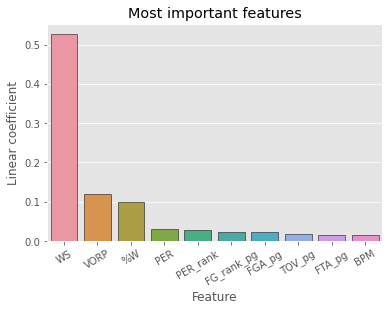

In [24]:
mod.display_feature_importances(best_model)

In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

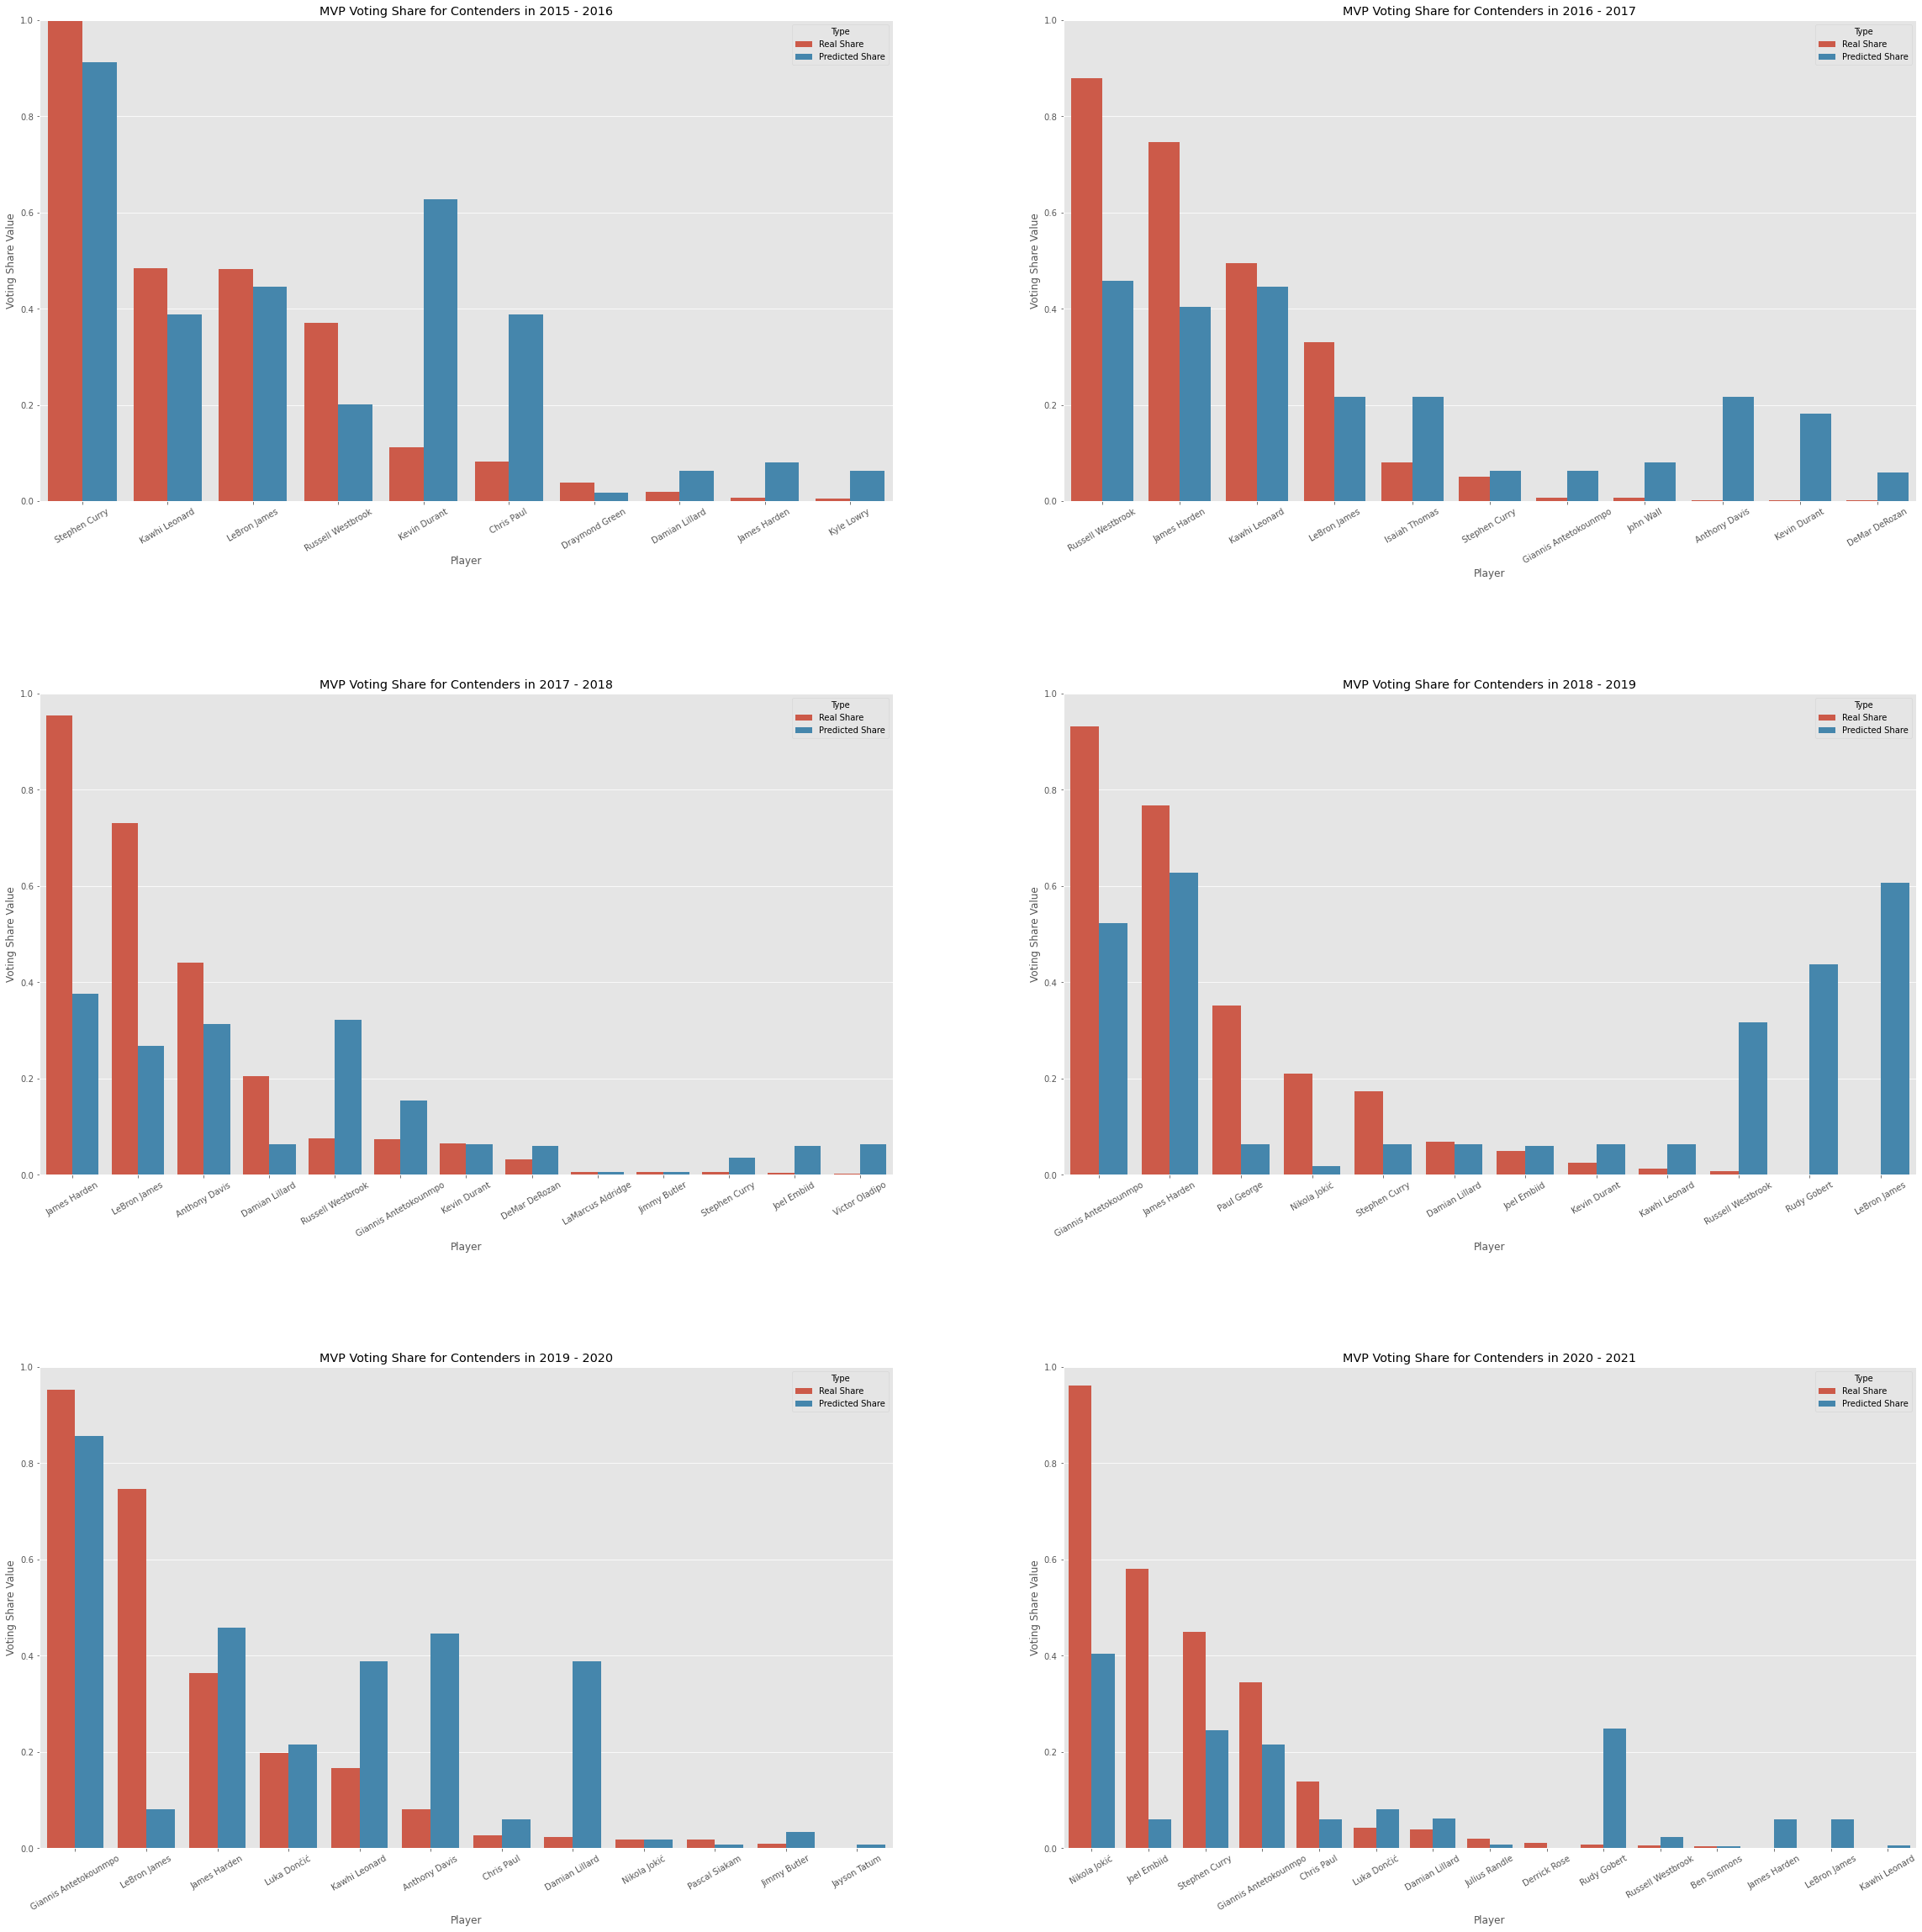

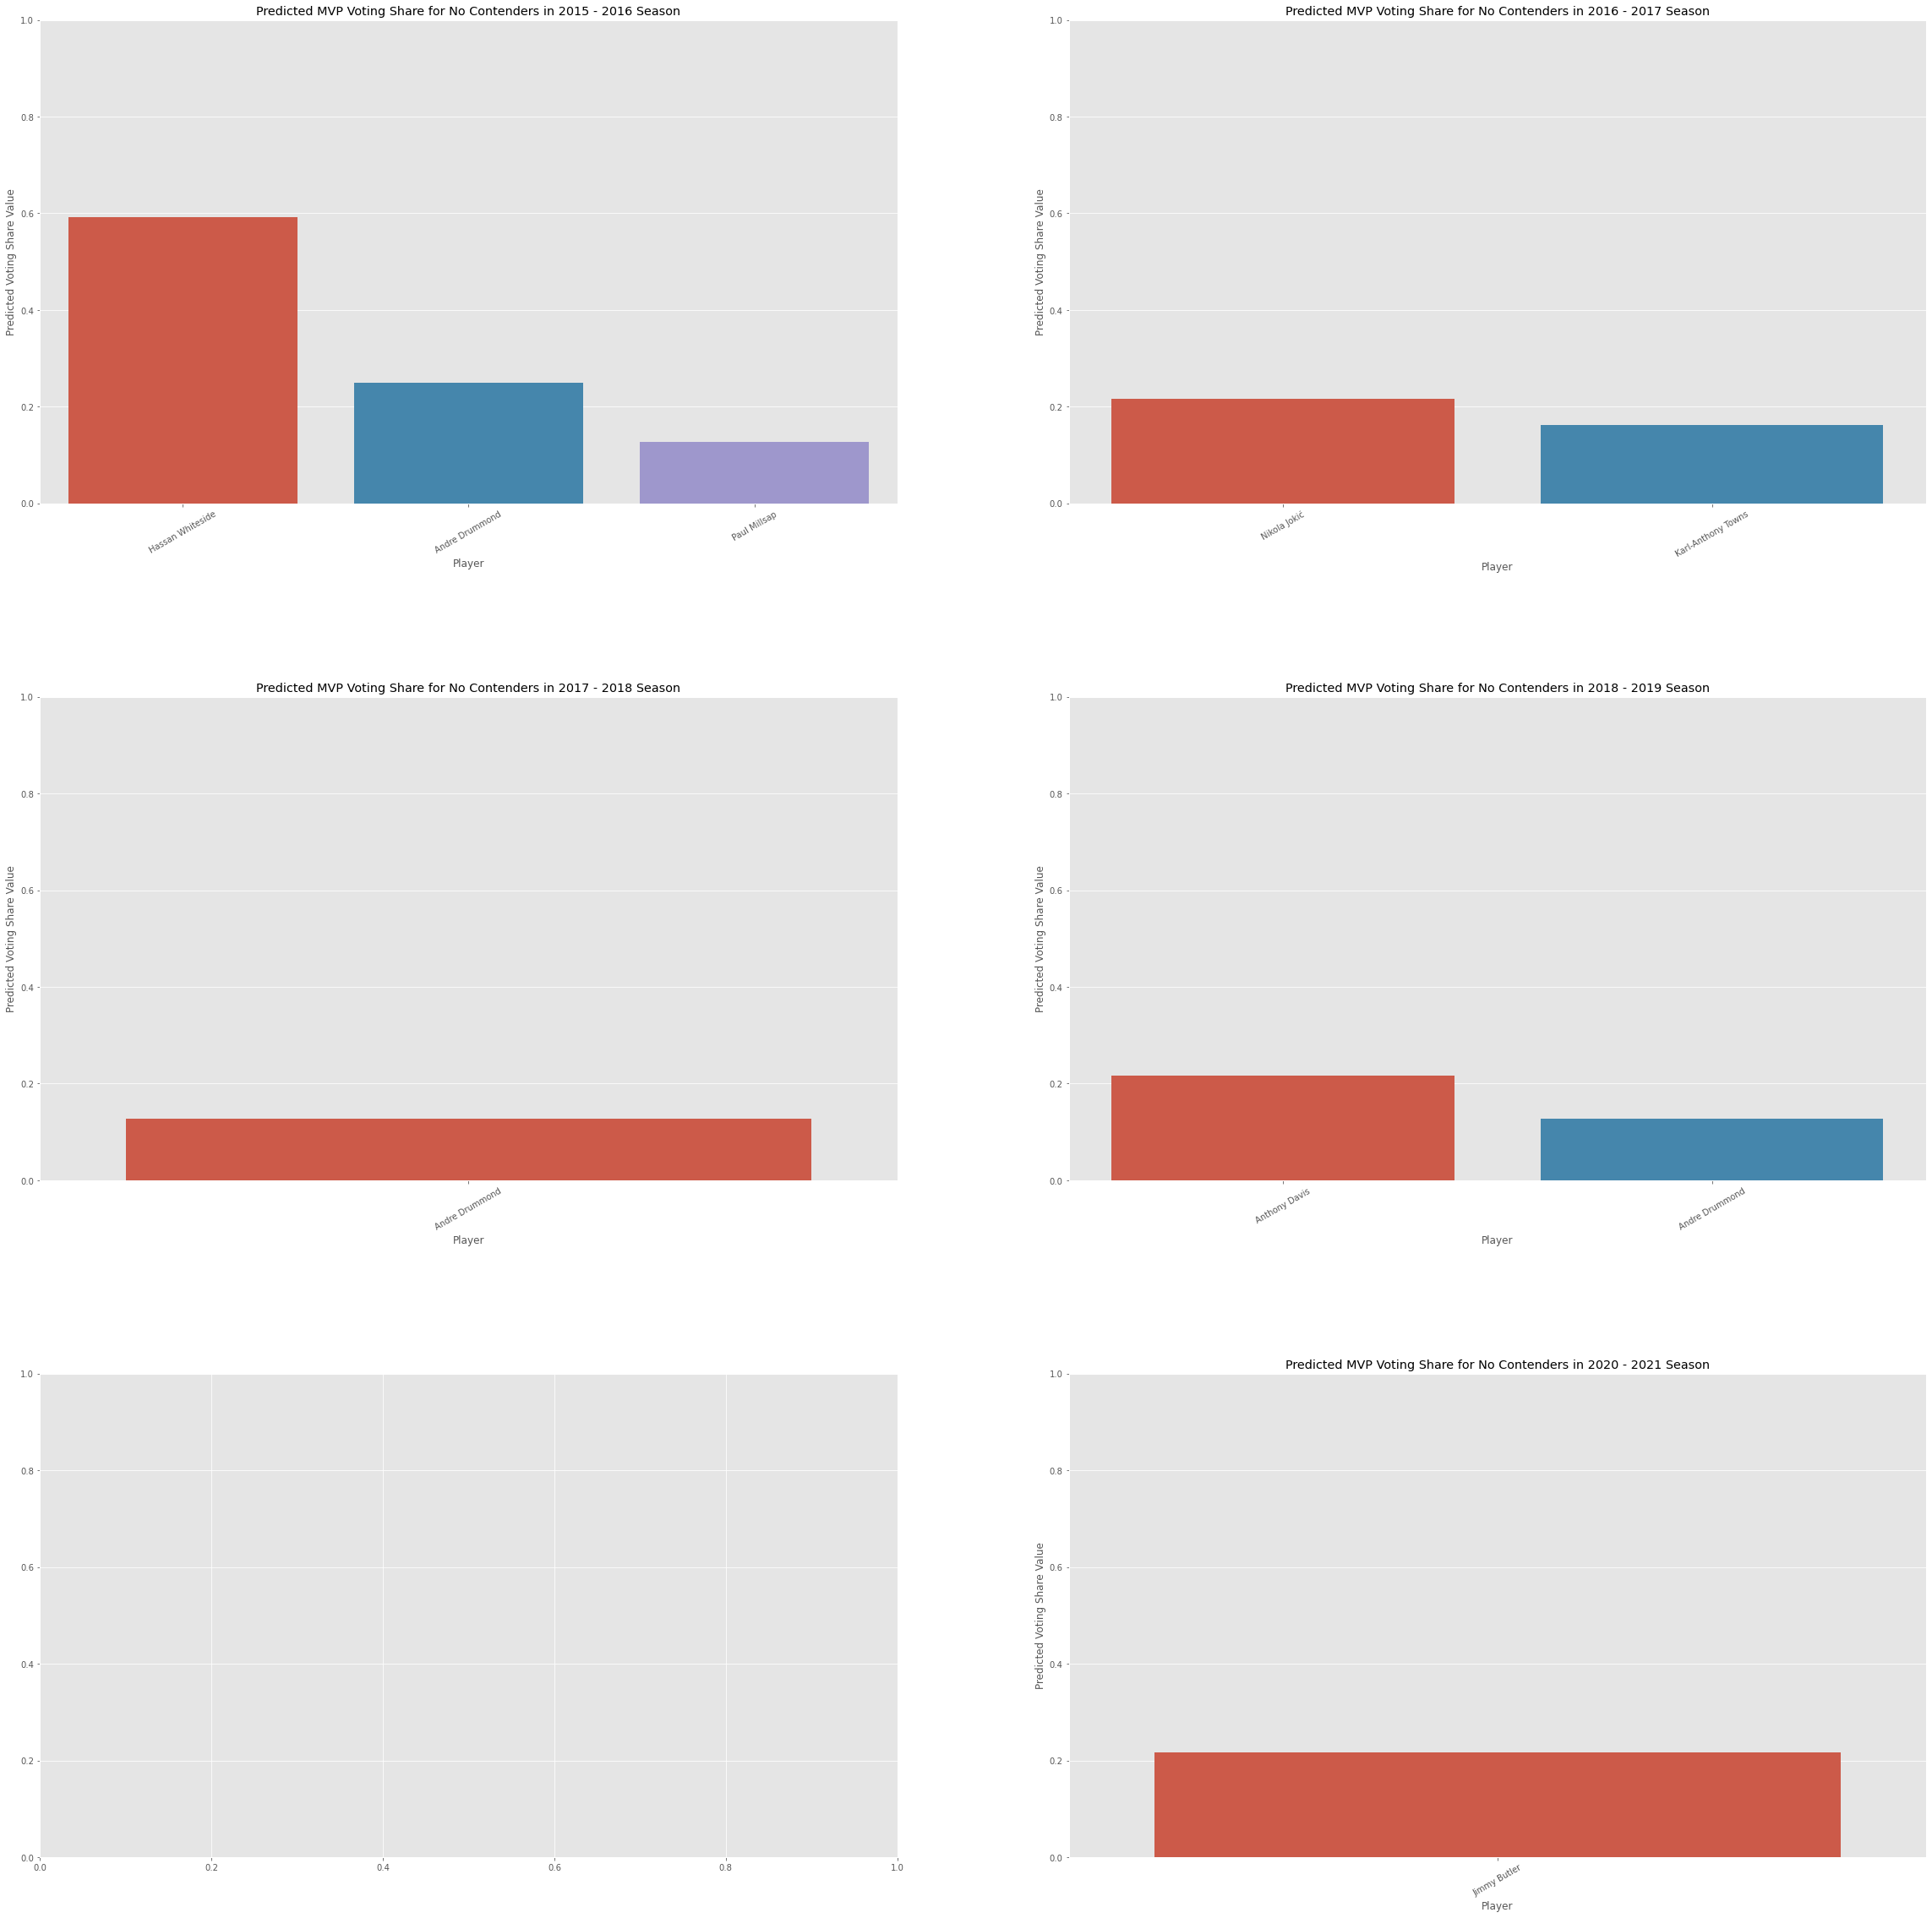

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)